In [1]:
from __future__ import absolute_import
from keras_unet_collection.layer_utils import *
from keras_unet_collection.activations import GELU, Snake
from keras_unet_collection._backbone_zoo import backbone_zoo, bach_norm_checker
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import ReLU, LeakyReLU, ELU, PReLU
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [2]:
def UNET_left(X, channel, kernel_size=3, stack_num=2, activation='ReLU', 
              pool=True, batch_norm=False, name='left0'):
    '''
    The encoder block of U-net.
    
    UNET_left(X, channel, kernel_size=3, stack_num=2, activation='ReLU', 
              pool=True, batch_norm=False, name='left0')
    
    Input
    ----------
        X: input tensor.
        channel: number of convolution filters.
        kernel_size: size of 2-d convolution kernels.
        stack_num: number of convolutional layers.
        activation: one of the `tensorflow.keras.layers` interface, e.g., 'ReLU'.
        pool: True or 'max' for MaxPooling2D.
              'ave' for AveragePooling2D.
              False for strided conv + batch norm + activation.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
        
    '''
    pool_size = 2
    
    X = encode_layer(X, channel, pool_size, pool, activation=activation, 
                     batch_norm=batch_norm, name='{}_encode'.format(name))

    X = CONV_stack(X, channel, kernel_size, stack_num=stack_num, activation=activation, 
                   batch_norm=batch_norm, name='{}_conv'.format(name))
    
    return X


def UNET_right(X, X_list, channel, kernel_size=3, 
               stack_num=2, activation='ReLU',
               unpool=True, batch_norm=False, concat=True, name='right0'):
    
    '''
    The decoder block of U-net.
    
    Input
    ----------
        X: input tensor.
        X_list: a list of other tensors that connected to the input tensor.
        channel: number of convolution filters.
        kernel_size: size of 2-d convolution kernels.
        stack_num: number of convolutional layers.
        activation: one of the `tensorflow.keras.layers` interface, e.g., 'ReLU'.
        unpool: True or 'bilinear' for Upsampling2D with bilinear interpolation.
                'nearest' for Upsampling2D with nearest interpolation.
                False for Conv2DTranspose + batch norm + activation.
        batch_norm: True for batch normalization, False otherwise.
        concat: True for concatenating the corresponded X_list elements.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
    
    '''
    
    pool_size = 2
    
    X = decode_layer(X, channel, pool_size, unpool, 
                     activation=activation, batch_norm=batch_norm, name='{}_decode'.format(name))
    
    # linear convolutional layers before concatenation
    X = CONV_stack(X, channel, kernel_size, stack_num=1, activation=activation, 
                   batch_norm=batch_norm, name='{}_conv_before_concat'.format(name))
    if concat:
        # <--- *stacked convolutional can be applied here
        X = concatenate([X,]+X_list, axis=3, name=name+'_concat')
    
    # Stacked convolutions after concatenation 
    X = CONV_stack(X, channel, kernel_size, stack_num=stack_num, activation=activation, 
                   batch_norm=batch_norm, name=name+'_conv_after_concat')
    
    return X

def unet_2d_base(input_tensor, filter_num, stack_num_down=2, stack_num_up=2, 
                 activation='ReLU', batch_norm=False, pool=True, unpool=True, 
                 backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet'):
    
    '''
    The base of U-net with an optional ImageNet-trained backbone.
    
    unet_2d_base(input_tensor, filter_num, stack_num_down=2, stack_num_up=2, 
                 activation='ReLU', batch_norm=False, pool=True, unpool=True, 
                 backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    
    ----------
    Ronneberger, O., Fischer, P. and Brox, T., 2015, October. U-net: Convolutional networks for biomedical image segmentation. 
    In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.
    
    Input
    ----------
        input_tensor: the input tensor of the base, e.g., `keras.layers.Inpyt((None, None, 3))`.
        filter_num: a list that defines the number of filters for each \
                    down- and upsampling levels. e.g., `[64, 128, 256, 512]`.
                    The depth is expected as `len(filter_num)`.
        stack_num_down: number of convolutional layers per downsampling level/block. 
        stack_num_up: number of convolutional layers (after concatenation) per upsampling level/block.
        activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interfaces, e.g., 'ReLU'.
        batch_norm: True for batch normalization.
        pool: True or 'max' for MaxPooling2D.
              'ave' for AveragePooling2D.
              False for strided conv + batch norm + activation.
        unpool: True or 'bilinear' for Upsampling2D with bilinear interpolation.
                'nearest' for Upsampling2D with nearest interpolation.
                False for Conv2DTranspose + batch norm + activation.
        name: prefix of the created keras model and its layers.
        
        ---------- (keywords of backbone options) ----------
        backbone_name: the bakcbone model name. Should be one of the `tensorflow.keras.applications` class.
                       None (default) means no backbone. 
                       Currently supported backbones are:
                       (1) VGG16, VGG19
                       (2) ResNet50, ResNet101, ResNet152
                       (3) ResNet50V2, ResNet101V2, ResNet152V2
                       (4) DenseNet121, DenseNet169, DenseNet201
                       (5) EfficientNetB[0-7]
        weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), 
                 or the path to the weights file to be loaded.
        freeze_backbone: True for a frozen backbone.
        freeze_batch_norm: False for not freezing batch normalization layers.
        
    Output
    ----------
        X: output tensor.
    
    '''
    
    activation_func = eval(activation)

    X_skip = []
    depth_ = len(filter_num)

    # no backbone cases
    if backbone is None:

        X = input_tensor

        # stacked conv2d before downsampling
        X = CONV_stack(X, filter_num[0], stack_num=stack_num_down, activation=activation, 
                       batch_norm=batch_norm, name='{}_down0'.format(name))
        X_skip.append(X)

        # downsampling blocks
        for i, f in enumerate(filter_num[1:]):
            X = UNET_left(X, f, stack_num=stack_num_down, activation=activation, pool=pool, 
                          batch_norm=batch_norm, name='{}_down{}'.format(name, i+1))        
            X_skip.append(X)

    # backbone cases
    else:
        # handling VGG16 and VGG19 separately
        if 'VGG' in backbone:
            backbone_ = backbone_zoo(backbone, weights, input_tensor, depth_, freeze_backbone, freeze_batch_norm)
            # collecting backbone feature maps
            X_skip = backbone_([input_tensor,])
            depth_encode = len(X_skip)
            
        # for other backbones
        else:
            backbone_ = backbone_zoo(backbone, weights, input_tensor, depth_-1, freeze_backbone, freeze_batch_norm)
            # collecting backbone feature maps
            X_skip = backbone_([input_tensor,])
            depth_encode = len(X_skip) + 1


        # extra conv2d blocks are applied
        # if downsampling levels of a backbone < user-specified downsampling levels
        if depth_encode < depth_:

            # begins at the deepest available tensor  
            X = X_skip[-1]

            # extra downsamplings
            for i in range(depth_-depth_encode):
                i_real = i + depth_encode

                X = UNET_left(X, filter_num[i_real], stack_num=stack_num_down, activation=activation, pool=pool, 
                              batch_norm=batch_norm, name='{}_down{}'.format(name, i_real+1))
                X_skip.append(X)

    # reverse indexing encoded feature maps
    X_skip = X_skip[::-1]
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    depth_decode = len(X_decode)

    # reverse indexing filter numbers
    filter_num_decode = filter_num[:-1][::-1]

    # upsampling with concatenation
    for i in range(depth_decode):
        X = UNET_right(X, [X_decode[i],], filter_num_decode[i], stack_num=stack_num_up, activation=activation, 
                       unpool=unpool, batch_norm=batch_norm, name='{}_up{}'.format(name, i))

    # if tensors for concatenation is not enough
    # then use upsampling without concatenation 
    if depth_decode < depth_-1:
        for i in range(depth_-depth_decode-1):
            i_real = i + depth_decode
            X = UNET_right(X, None, filter_num_decode[i_real], stack_num=stack_num_up, activation=activation, 
                       unpool=unpool, batch_norm=batch_norm, concat=False, name='{}_up{}'.format(name, i_real))   
    return X

def unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
            activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
            backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet'):
    '''
    U-net with an optional ImageNet-trained bakcbone.
    
    unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
            activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
            backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet')
    
    ----------
    Ronneberger, O., Fischer, P. and Brox, T., 2015, October. U-net: Convolutional networks for biomedical image segmentation. 
    In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.
    
    Input
    ----------
        input_size: the size/shape of network input, e.g., `(128, 128, 3)`.
        filter_num: a list that defines the number of filters for each \
                    down- and upsampling levels. e.g., `[64, 128, 256, 512]`.
                    The depth is expected as `len(filter_num)`.
        n_labels: number of output labels.
        stack_num_down: number of convolutional layers per downsampling level/block. 
        stack_num_up: number of convolutional layers (after concatenation) per upsampling level/block.
        activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interfaces, e.g., 'ReLU'.
        output_activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interface or 'Sigmoid'.
                           Default option is 'Softmax'.
                           if None is received, then linear activation is applied.
        batch_norm: True for batch normalization.
        pool: True or 'max' for MaxPooling2D.
              'ave' for AveragePooling2D.
              False for strided conv + batch norm + activation.
        unpool: True or 'bilinear' for Upsampling2D with bilinear interpolation.
                'nearest' for Upsampling2D with nearest interpolation.
                False for Conv2DTranspose + batch norm + activation.                 
        name: prefix of the created keras model and its layers.
        
        ---------- (keywords of backbone options) ----------
        backbone_name: the bakcbone model name. Should be one of the `tensorflow.keras.applications` class.
                       None (default) means no backbone. 
                       Currently supported backbones are:
                       (1) VGG16, VGG19
                       (2) ResNet50, ResNet101, ResNet152
                       (3) ResNet50V2, ResNet101V2, ResNet152V2
                       (4) DenseNet121, DenseNet169, DenseNet201
                       (5) EfficientNetB[0-7]
        weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), 
                 or the path to the weights file to be loaded.
        freeze_backbone: True for a frozen backbone.
        freeze_batch_norm: False for not freezing batch normalization layers.
        
    Output
    ----------
        model: a keras model.
    
    '''
    activation_func = eval(activation)
    
    if backbone is not None:
        bach_norm_checker(backbone, batch_norm)
        
    IN = Input(input_size)
    
    # base    
    X = unet_2d_base(IN, filter_num, stack_num_down=stack_num_down, stack_num_up=stack_num_up, 
                     activation=activation, batch_norm=batch_norm, pool=pool, unpool=unpool, 
                     backbone=backbone, weights=weights, freeze_backbone=freeze_backbone, 
                     freeze_batch_norm=freeze_backbone, name=name)
    
    # output layer
    OUT = CONV_output(X, n_labels, kernel_size=1, activation=output_activation, name='{}_output'.format(name))
    
    # functional API model
    model = Model(inputs=[IN,], outputs=[OUT,], name='{}_model'.format(name))
    
    return model

In [3]:
# Imagen reescalada (más liviana para tu RTX 3050)
IMG_SIZE = (128, 128)

# Número de clases incluyendo fondo
N_CLASSES = 9

# Tamaños por nivel (U-Net reducida)
FILTER_NUM = [32, 64, 128, 256]

# Batch size bajo por límite de VRAM
BATCH_SIZE = 2

In [4]:
color_to_class = {
    (0, 0, 0): 0,         # fondo
    (100, 0, 100): 1,     # hígado (violeta oscuro)
    (255, 255, 0): 2,     # riñón (amarillo)
    (0, 0, 255): 3,       # páncreas (azul)
    (255, 0, 0): 4,       # vasos (rojo)
    (0, 255, 255): 5,     # suprarrenales (celeste)
    (0, 255, 0): 6,       # vesícula (verde)
    (255, 255, 255): 7,   # huesos (blanco)
    (255, 0, 255): 8      # bazo (rosado)
}

In [5]:
def rgb_mask_to_class(mask_rgb):
    h, w, _ = mask_rgb.shape
    mask_class = np.zeros((h, w), dtype=np.uint8)

    for color, class_id in color_to_class.items():
        matches = np.all(mask_rgb == color, axis=-1)
        mask_class[matches] = class_id

    return mask_class

In [6]:
class UltrasoundDataset(Sequence):
    def __init__(self, file_list, img_dir, mask_dir, batch_size=2, img_size=(128,128), n_classes=9):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_classes = n_classes

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.file_list[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_x, batch_y = [], []

        for fname in batch_files:
            # Imagen
            img = cv2.imread(os.path.join(self.img_dir, fname), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = img.astype(np.float32) / 255.0
            img = np.expand_dims(img, axis=-1)

            # Máscara
            mask = cv2.imread(os.path.join(self.mask_dir, fname.replace(".jpg", ".png")))
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
            mask_class = rgb_mask_to_class(mask)
            mask_one_hot = to_categorical(mask_class, num_classes=self.n_classes)

            batch_x.append(img)
            batch_y.append(mask_one_hot)

        return np.array(batch_x), np.array(batch_y)

In [7]:
BASE_PATH = "archive/abdominal_US/AUS"
IMG_DIR = os.path.join(BASE_PATH, "images/train")
MASK_DIR = os.path.join(BASE_PATH, "annotations/train")

# Lista de archivos y split
all_files = sorted([f for f in os.listdir(IMG_DIR) if f.endswith(".png")])
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Generadores
train_gen = UltrasoundDataset(train_files, IMG_DIR, MASK_DIR, batch_size=BATCH_SIZE, img_size=IMG_SIZE, n_classes=N_CLASSES)
val_gen = UltrasoundDataset(val_files, IMG_DIR, MASK_DIR, batch_size=BATCH_SIZE, img_size=IMG_SIZE, n_classes=N_CLASSES)

In [8]:
model = unet_2d(
    input_size=(IMG_SIZE[0], IMG_SIZE[1], 1),
    filter_num=FILTER_NUM,
    n_labels=N_CLASSES,
    stack_num_down=2,
    stack_num_up=2,
    activation='ReLU',
    output_activation='Softmax',
    batch_norm=True,
    pool=True,
    unpool=True,
    backbone=None
)


In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    ModelCheckpoint("best_multiclass_model.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]


In [11]:
gpus = tf.config.list_physical_devices('GPU')
print("GPUs disponibles:", gpus)

# Ver si TensorFlow está utilizando la GPU
print("TensorFlow está usando GPU:", tf.test.is_gpu_available())

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TensorFlow está usando GPU: True


In [12]:
model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

Epoch 1/50
253/253 [==============================] - 62s 116ms/step - loss: 0.6476 - accuracy: 0.8240 - val_loss: 1.9938 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 2/50
253/253 [==============================] - 12s 47ms/step - loss: 0.4112 - accuracy: 0.8650 - val_loss: 2.2630 - val_accuracy: 0.6378 - lr: 0.0010
Epoch 3/50
253/253 [==============================] - 12s 48ms/step - loss: 0.3652 - accuracy: 0.8815 - val_loss: 0.5955 - val_accuracy: 0.7827 - lr: 0.0010
Epoch 4/50
253/253 [==============================] - 12s 48ms/step - loss: 0.3421 - accuracy: 0.8880 - val_loss: 0.3887 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 5/50
253/253 [==============================] - 12s 47ms/step - loss: 0.3197 - accuracy: 0.8948 - val_loss: 0.5217 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 6/50
253/253 [==============================] - 12s 49ms/step - loss: 0.3098 - accuracy: 0.8975 - val_loss: 0.2539 - val_accuracy: 0.9213 - lr: 0.0010
Epoch 7/50
253/253 [==============================] - 12s

In [8]:
class_to_color = {
    0: (0, 0, 0),           # fondo
    1: (100, 0, 100),       # hígado (violeta oscuro)
    2: (255, 255, 0),       # riñón (amarillo)
    3: (0, 0, 255),         # páncreas (azul)
    4: (255, 0, 0),         # vasos (rojo)
    5: (0, 255, 255),       # suprarrenales (celeste)
    6: (0, 255, 0),         # vesícula (verde)
    7: (255, 255, 255),     # huesos (blanco)
    8: (255, 0, 255),       # bazo (rosado)
}

In [9]:
def mask_class_to_rgb(mask_class):
    h, w = mask_class.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in class_to_color.items():
        rgb_mask[mask_class == class_id] = color
    return rgb_mask

1/1 [==============================] - 0s 23ms/step


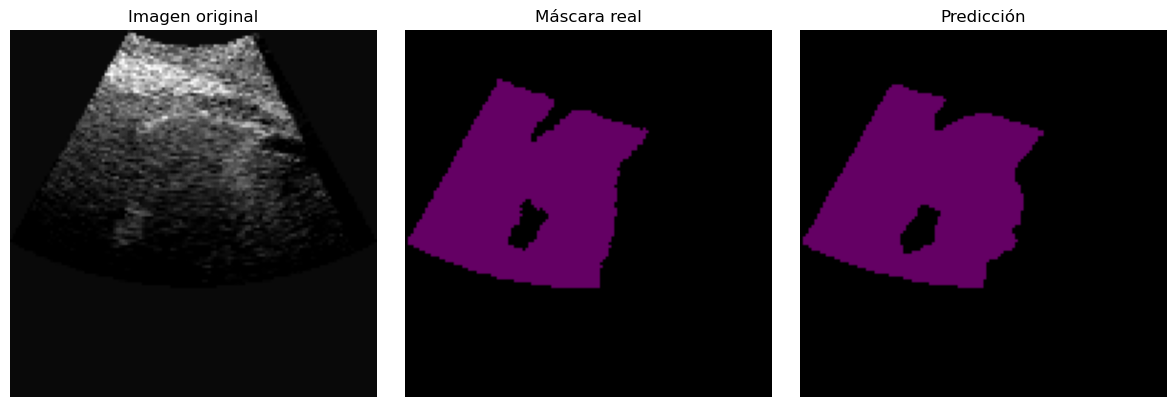

In [16]:
import random
fname = random.choice(train_files)

# Cargar imagen
img = cv2.imread(os.path.join(IMG_DIR, fname), cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, IMG_SIZE)
img_input = img_resized.astype(np.float32) / 255.0
img_input = np.expand_dims(np.expand_dims(img_input, -1), 0)  # (1, H, W, 1)

# Cargar máscara real
mask = cv2.imread(os.path.join(MASK_DIR, fname))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
mask_class = rgb_mask_to_class(mask)
mask_rgb_gt = mask_class_to_rgb(mask_class)

# Predicción
pred = model.predict(img_input)[0]  # (H, W, C)
pred_class = np.argmax(pred, axis=-1)  # (H, W)
pred_rgb = mask_class_to_rgb(pred_class)

# Visualización
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Imagen original")
plt.imshow(img_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Máscara real")
plt.imshow(mask_rgb_gt)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicción")
plt.imshow(pred_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 20ms/step


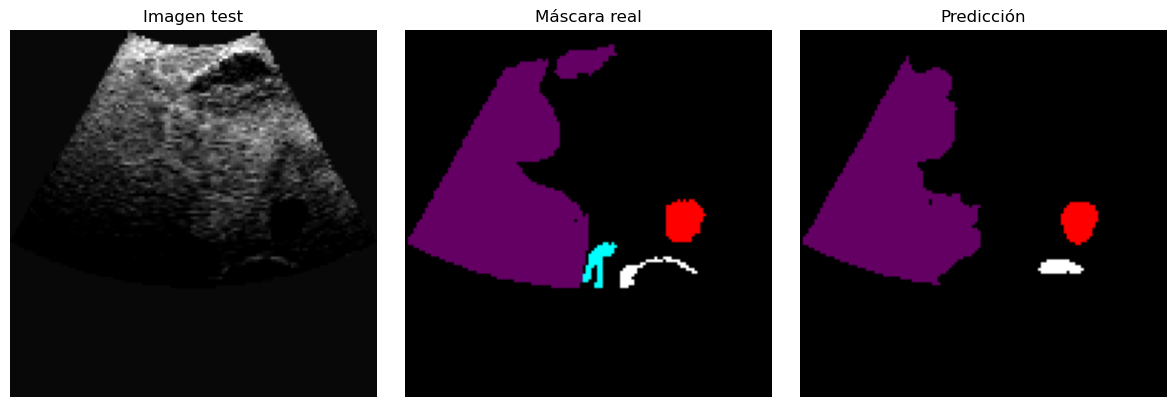

Probando con archivo de test: ct1-23.png


In [27]:
# Paths para test
TEST_IMG_DIR = "archive/abdominal_US/AUS/images/test"
TEST_MASK_DIR = "archive/abdominal_US/AUS/annotations/test"

# Obtener lista de archivos disponibles en test
test_files = sorted([f for f in os.listdir(TEST_IMG_DIR) if f.endswith(".png")])

# Elegir una imagen al azar
fname = random.choice(test_files)

# ----------- Cargar imagen de test -----------
img = cv2.imread(os.path.join(TEST_IMG_DIR, fname), cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, IMG_SIZE)
img_input = img_resized.astype(np.float32) / 255.0
img_input = np.expand_dims(np.expand_dims(img_input, -1), 0)  # (1, H, W, 1)

# ----------- Cargar máscara real de test -----------
mask = cv2.imread(os.path.join(TEST_MASK_DIR, fname))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
mask_class = rgb_mask_to_class(mask)
mask_rgb_gt = mask_class_to_rgb(mask_class)

# ----------- Predicción -----------
pred = model.predict(img_input)[0]  # (H, W, C)
pred_class = np.argmax(pred, axis=-1)  # (H, W)
pred_rgb = mask_class_to_rgb(pred_class)

# ----------- Visualización -----------
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Imagen test")
plt.imshow(img_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Máscara real")
plt.imshow(mask_rgb_gt)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicción")
plt.imshow(pred_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

print("Probando con archivo de test:", fname)

In [10]:
model = load_model("best_multiclass_model.h5")

1/1 [==============================] - 0s 78ms/step


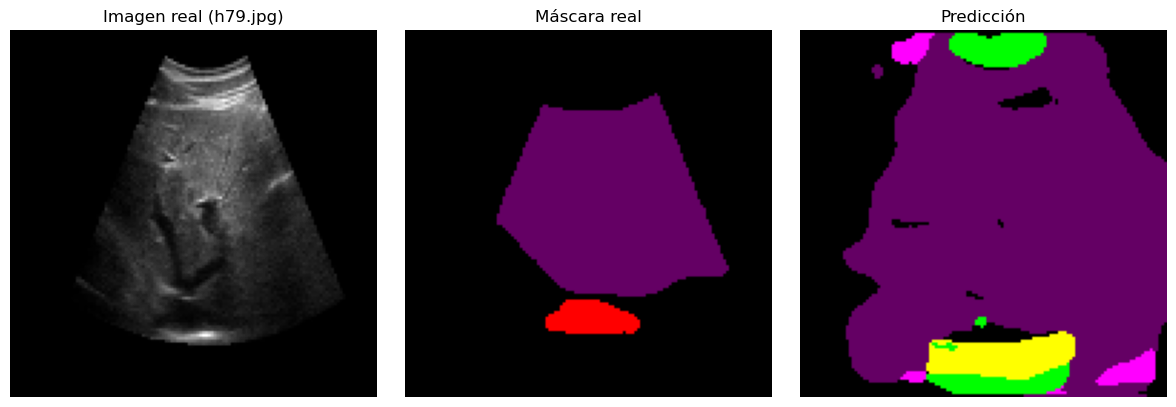

In [12]:
# === Rutas ===
real_img_path = "archive/abdominal_US/RUS/images/test/b6.jpg"
real_mask_path = "archive/abdominal_US/RUS/annotations/test/b6.png"

# === Leer imagen real (JPG) y convertir a PNG en memoria
img = cv2.imread(real_img_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, (128, 128))
img_norm = img_resized.astype(np.float32) / 255.0
img_input = np.expand_dims(img_norm, axis=(0, -1))  # (1, 128, 128, 1)

# === Leer máscara real (PNG)
mask = cv2.imread(real_mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask_resized = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

# === Predicción
pred = model.predict(img_input)[0]  # (128, 128, 9)
pred_class = np.argmax(pred, axis=-1)  # (128, 128)
pred_rgb = mask_class_to_rgb(pred_class)

# === Visualización
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Imagen real (h79.jpg)")
plt.imshow(img_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Máscara real")
plt.imshow(mask_resized)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicción")
plt.imshow(pred_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
model = load_model("best_multiclass_model.h5")

1/1 [==============================] - 0s 24ms/step


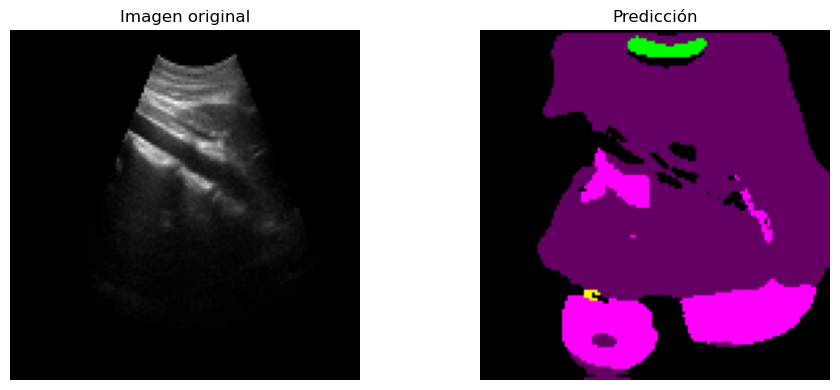

Probando con archivo: a2.jpg


In [28]:
IMG_DIR = "archive/abdominal_US/RUS/images/test"

filename = "a2.jpg"  # ← cámbialo según el archivo que desees probar

# Cargar imagen
img_path = os.path.join(IMG_DIR, filename)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, IMG_SIZE)
img_input = img_resized.astype(np.float32) / 255.0
img_input = np.expand_dims(np.expand_dims(img_input, -1), 0)  # (1, H, W, 1)

# Predicción
pred = model.predict(img_input)[0]  # (H, W, C)
pred_class = np.argmax(pred, axis=-1)  # (H, W)
pred_rgb = mask_class_to_rgb(pred_class)  # Convertir a RGB para visualizar con colores

# Visualización
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Imagen original")
plt.imshow(img_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicción")
plt.imshow(pred_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

print("Probando con archivo:", filename)

In [17]:
# Congelar todas las capas inicialmente
for layer in model.layers:
    layer.trainable = False

# (Opcional) Descongelar las últimas N capas del decoder
for layer in model.layers[-10:]:
    layer.trainable = True

In [30]:
# Paths reales
REAL_IMG_DIR = "archive/abdominal_US/RUS/images/test"
REAL_MASK_DIR = "archive/abdominal_US/RUS/annotations/test"

# Lista de nombres de máscara sin extensión
mask_filenames = [os.path.splitext(f)[0] for f in os.listdir(REAL_MASK_DIR) if f.endswith(".png")]

# Verifica cuáles existen como .jpg en la carpeta de imágenes
real_files = [f + ".jpg" for f in mask_filenames if os.path.exists(os.path.join(REAL_IMG_DIR, f + ".jpg"))]

print(f"Total de pares válidos (imagen+máscara): {len(real_files)}")

Total de pares válidos (imagen+máscara): 60


In [31]:
# Dividir en entrenamiento y validación
real_train, real_val = train_test_split(real_files, test_size=0.2, random_state=42)

# Generadores
real_train_gen = UltrasoundDataset(real_train, REAL_IMG_DIR, REAL_MASK_DIR,
                                   batch_size=BATCH_SIZE, img_size=IMG_SIZE, n_classes=N_CLASSES)

real_val_gen = UltrasoundDataset(real_val, REAL_IMG_DIR, REAL_MASK_DIR,
                                 batch_size=BATCH_SIZE, img_size=IMG_SIZE, n_classes=N_CLASSES)

In [24]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Muy conservador
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
fine_tune_callbacks = [
    ModelCheckpoint("fine_tuned_model.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss"),
    ReduceLROnPlateau(patience=4, factor=0.5, min_lr=1e-7)
]

In [32]:
model.fit(
    real_train_gen,
    validation_data=real_val_gen,
    epochs=30,
    callbacks=fine_tune_callbacks
)

Epoch 1/30
24/24 [==============================] - 6s 85ms/step - loss: 2.6206 - accuracy: 0.0275 - val_loss: 2.1832 - val_accuracy: 0.1215 - lr: 1.0000e-05
Epoch 2/30
24/24 [==============================] - 1s 41ms/step - loss: 2.4304 - accuracy: 0.0757 - val_loss: 2.1484 - val_accuracy: 0.1206 - lr: 1.0000e-05
Epoch 3/30
24/24 [==============================] - 1s 40ms/step - loss: 2.3035 - accuracy: 0.1463 - val_loss: 2.1028 - val_accuracy: 0.1314 - lr: 1.0000e-05
Epoch 4/30
24/24 [==============================] - 1s 40ms/step - loss: 2.2058 - accuracy: 0.2226 - val_loss: 2.0434 - val_accuracy: 0.6971 - lr: 1.0000e-05
Epoch 5/30
24/24 [==============================] - 1s 40ms/step - loss: 2.1234 - accuracy: 0.3136 - val_loss: 1.9828 - val_accuracy: 0.7854 - lr: 1.0000e-05
Epoch 6/30
24/24 [==============================] - 1s 40ms/step - loss: 2.0522 - accuracy: 0.4024 - val_loss: 1.9396 - val_accuracy: 0.7850 - lr: 1.0000e-05
Epoch 7/30
24/24 [==============================] - 

1/1 [==============================] - 0s 30ms/step


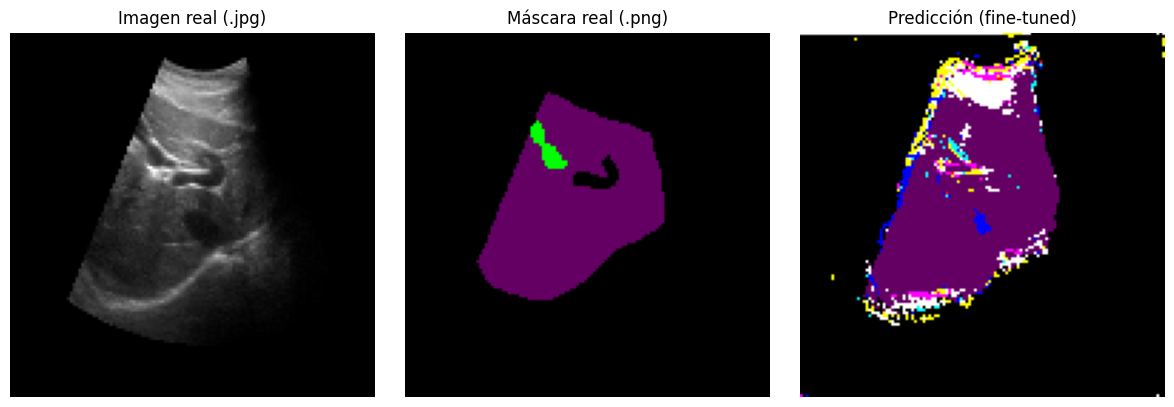

In [41]:
# === CONFIGURACIÓN ===
IMG_DIR = "archive/abdominal_US/RUS/images/test"
MASK_DIR = "archive/abdominal_US/RUS/annotations/test"
IMG_SIZE = (128, 128)

# === CAMBIA ESTE NOMBRE PARA PROBAR OTRAS ===
filename = "a9.jpg"  # <-- Debe estar en real_files

# === Cargar imagen (.jpg) ===
img_path = os.path.join(IMG_DIR, filename)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, IMG_SIZE)
img_input = img_resized.astype(np.float32) / 255.0
img_input = np.expand_dims(np.expand_dims(img_input, -1), 0)  # (1, H, W, 1)

# === Cargar máscara real (.png) ===
mask_filename = filename.replace(".jpg", ".png")
mask_path = os.path.join(MASK_DIR, mask_filename)
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
mask_class = rgb_mask_to_class(mask)
mask_rgb_gt = mask_class_to_rgb(mask_class)

# === Predicción del modelo fine-tuneado ===
pred = model.predict(img_input)[0]  # (H, W, C)
pred_class = np.argmax(pred, axis=-1)  # (H, W)
pred_rgb = mask_class_to_rgb(pred_class)

# === Visualización ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Imagen real (.jpg)")
plt.imshow(img_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Máscara real (.png)")
plt.imshow(mask_rgb_gt)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicción (fine-tuned)")
plt.imshow(pred_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

In [42]:
# Descongelar todas las capas
for layer in model.layers:
    layer.trainable = True

from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-6),  # Muy bajo para no destruir los pesos previos
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [44]:
from tensorflow.keras.utils import Sequence
import imgaug.augmenters as iaa

# Augmentaciones fuertes pero razonables
AUGMENTER = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.3),
    iaa.Affine(rotate=(-20, 20), scale=(0.9, 1.1), shear=(-10, 10)),
    iaa.ElasticTransformation(alpha=50, sigma=5),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),
    iaa.ContrastNormalization((0.75, 1.25)),
    iaa.Multiply((0.8, 1.2))
])

C:\Users\gabri\anaconda3\envs\p300\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [48]:
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

class AugmentedUltrasoundDataset(Sequence):
    def __init__(self, file_list, img_dir, mask_dir, augmenter=None, batch_size=2, img_size=(128,128), n_classes=9):
        self.file_list = file_list
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.augmenter = augmenter
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_classes = n_classes

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.file_list[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_x, batch_y = [], []

        for fname in batch_files:
            # Cargar imagen .jpg
            img = cv2.imread(os.path.join(self.img_dir, fname), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, self.img_size)
            img = img.astype(np.uint8)  # imgaug espera uint8
            img = np.expand_dims(img, axis=-1)

            # Cargar máscara .png
            mask = cv2.imread(os.path.join(self.mask_dir, fname.replace(".jpg", ".png")))
            if mask is None:
                continue
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)
            mask_class = rgb_mask_to_class(mask)

            # Augmentación conjunta imagen + máscara
            if self.augmenter:
                segmap = SegmentationMapsOnImage(mask_class, shape=img.shape)
                img, segmap_aug = self.augmenter(image=img, segmentation_maps=segmap)
                mask_class = segmap_aug.get_arr()

            # Normalización + One-hot
            img = img.astype(np.float32) / 255.0
            mask_one_hot = to_categorical(mask_class, num_classes=self.n_classes)

            batch_x.append(img)
            batch_y.append(mask_one_hot)

        return np.array(batch_x), np.array(batch_y)


In [49]:
aug_train_gen = AugmentedUltrasoundDataset(real_train, REAL_IMG_DIR, REAL_MASK_DIR,
                                           augmenter=AUGMENTER,
                                           batch_size=BATCH_SIZE, img_size=IMG_SIZE, n_classes=N_CLASSES)

aug_val_gen = UltrasoundDataset(real_val, REAL_IMG_DIR, REAL_MASK_DIR,
                                batch_size=BATCH_SIZE, img_size=IMG_SIZE, n_classes=N_CLASSES)

In [50]:
model.fit(
    aug_train_gen,
    validation_data=aug_val_gen,
    epochs=30,
    callbacks=fine_tune_callbacks
)

Epoch 1/30
24/24 [==============================] - 6s 104ms/step - loss: 1.6238 - accuracy: 0.7543 - val_loss: 1.4712 - val_accuracy: 0.8150 - lr: 1.0000e-06
Epoch 2/30
24/24 [==============================] - 2s 64ms/step - loss: 1.6201 - accuracy: 0.7537 - val_loss: 1.5518 - val_accuracy: 0.8083 - lr: 1.0000e-06
Epoch 3/30
24/24 [==============================] - 1s 59ms/step - loss: 1.6212 - accuracy: 0.7646 - val_loss: 1.5528 - val_accuracy: 0.8056 - lr: 1.0000e-06
Epoch 4/30
24/24 [==============================] - 1s 56ms/step - loss: 1.6058 - accuracy: 0.7570 - val_loss: 1.5510 - val_accuracy: 0.8025 - lr: 1.0000e-06
Epoch 5/30
24/24 [==============================] - 1s 51ms/step - loss: 1.5864 - accuracy: 0.7743 - val_loss: 1.5380 - val_accuracy: 0.8014 - lr: 1.0000e-06
Epoch 6/30
24/24 [==============================] - 1s 50ms/step - loss: 1.5732 - accuracy: 0.7724 - val_loss: 1.5374 - val_accuracy: 0.8010 - lr: 5.0000e-07
Epoch 7/30
24/24 [==============================] -

1/1 [==============================] - 0s 458ms/step


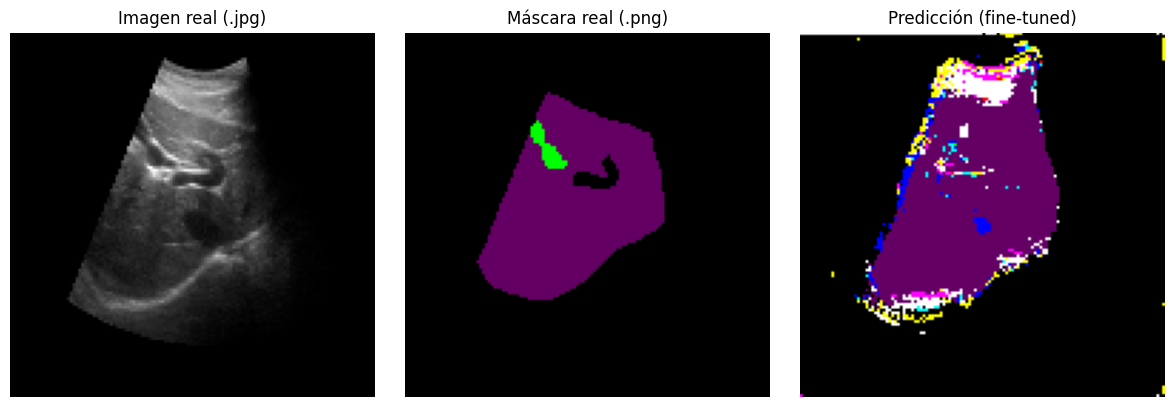

In [51]:
# === CONFIGURACIÓN ===
IMG_DIR = "archive/abdominal_US/RUS/images/test"
MASK_DIR = "archive/abdominal_US/RUS/annotations/test"
IMG_SIZE = (128, 128)

# === CAMBIA ESTE NOMBRE PARA PROBAR OTRAS ===
filename = "a9.jpg"  # <-- Debe estar en real_files

# === Cargar imagen (.jpg) ===
img_path = os.path.join(IMG_DIR, filename)
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_resized = cv2.resize(img, IMG_SIZE)
img_input = img_resized.astype(np.float32) / 255.0
img_input = np.expand_dims(np.expand_dims(img_input, -1), 0)  # (1, H, W, 1)

# === Cargar máscara real (.png) ===
mask_filename = filename.replace(".jpg", ".png")
mask_path = os.path.join(MASK_DIR, mask_filename)
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
mask_class = rgb_mask_to_class(mask)
mask_rgb_gt = mask_class_to_rgb(mask_class)

# === Predicción del modelo fine-tuneado ===
pred = model.predict(img_input)[0]  # (H, W, C)
pred_class = np.argmax(pred, axis=-1)  # (H, W)
pred_rgb = mask_class_to_rgb(pred_class)

# === Visualización ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Imagen real (.jpg)")
plt.imshow(img_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Máscara real (.png)")
plt.imshow(mask_rgb_gt)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicción (fine-tuned)")
plt.imshow(pred_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()